# GWAS Analysis

I want to see whether the eQTLs are enriched for GWAS hits.

In [1]:
import glob
import os
import random
import subprocess

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import tabix

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [3]:
outdir = os.path.join(ciepy.root, 'output',
                      'gwas_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gwas_analysis')
cpy.makedir(private_outdir)

In [4]:
gwas = pd.read_table(cpy.gwas_catalog, low_memory=False)
gwas = gwas.dropna(subset=['CHR_ID', 'CHR_POS'])
gwas['CHR_ID'] = 'chr' + gwas.CHR_ID.astype(int).astype(str)
gwas['CHR_POS'] = gwas.CHR_POS.astype(int)
gwas['hg38_loc'] = gwas.CHR_ID + ':' + gwas.CHR_POS.astype(str)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)
most_sig = most_sig.join(qvalues)
most_sig = most_sig.drop_duplicates(subset=['gene'])
sig = most_sig[most_sig.sig_gene]
sig = sig.drop_duplicates(subset=['gene'])

## Get Null Sets

I need to obtain a set of SNVs to calculate a null distribution with. 
These null SNVs should not be significant for an eQTL and should be
matched based on

* distance to TSS
* MAF
* number of SNVs in LD with

My matching is based Grubert et al. and Waszak et al. I'll stratify MAF from 0 to 0.5 in 
0.05 intervals. For TSS, I'll define the distribution by log distance 
from all SNPs to TSS and binned into 10 breaks. 

The `top_snv_results_sorted.tsv` file has all of the EMMAX results appended together
with the lowest $p$-value for each SNV (some SNVs were tested for multiple genes). 
I can take the lowest $p$-value for each SNV to make sure it isn't significant. 
The file also contains the MAF. I can add the TSS distance.

In [14]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'top_snv_results_sorted.tsv.gz')
names = ['CHROM', 'BEG', 'END', 'MARKER_ID', 'NS',
         'AC', 'CALLRATE', 'GENOCNT', 'MAF', 'STAT', 
         'PVALUE', 'BETA', 'SEBETA', 'R2']
snvs = pd.read_table(fn, header=None, low_memory=False, names=names)
snvs.index = ('chr' + snvs.CHROM.astype(str) + ':' + snvs.BEG.astype(str))
snvs.CHROM = 'chr' + snvs.CHROM.astype(str)
snvs['MAF_bin'] = pd.cut(snvs.MAF, np.arange(0, 0.55, 0.05))

In [17]:
snvs['ld_count'] = 0
for c in set(snvs.CHROM):
    t = snvs[snvs.CHROM == c]
    s = '\n'.join(c.strip('chr') + '\t' + (t.BEG - 1).astype(str) + '\t' + t.END.astype(str)) + '\n'
    bt = pbt.BedTool(s, from_string=True)
    ld_c = pbt.BedTool('/raid3/publicdata/1KGP/LD/counts/{}_EUR_ld_all.hap_08_counts.bed'.format(c))
    res = bt.intersect(ld_c, sorted=True, wo=True)
    ind = []
    count = []
    for r in res:
        ind.append('chr{}:{}'.format(r.chrom, r.end))
        count.append(int(r.fields[-2]))
    snvs.ix[ind, 'ld_count'] = count
snvs['ld_count_bin'] = pd.cut(np.log10(snvs.ld_count + 1), bins=10)

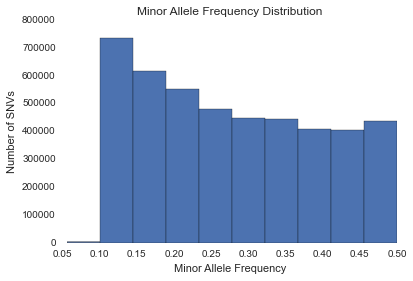

In [18]:
snvs.MAF.hist()
plt.ylabel('Number of SNVs')
plt.xlabel('Minor Allele Frequency')
plt.title('Minor Allele Frequency Distribution');

Now I'll find the distance to the nearest TSS for each top SNV.

In [22]:
tss = pbt.BedTool(cpy.gencode_tss_bed)
snvs['BEG'] = snvs.BEG - 1
fn = os.path.join(outdir, 'top_snvs.bed')
snvs[['CHROM', 'BEG', 'END']].to_csv(fn, sep='\t', index=False, header=False)
snvs['BEG'] = snvs.BEG + 1
bt = pbt.BedTool(fn)
res = bt.closest(tss, D='b', sorted=True, t='first')
dist = []
r = res.to_dataframe()
snvs['tss_dist'] = r['blockCount'].values
snvs['tss_dist_bin'] = pd.cut(np.log10(snvs.tss_dist.abs() + 1), 10)

In [31]:
bins = {'maf':sorted(list(set(snvs.MAF_bin))),
        'ld':sorted(list(set(snvs.ld_count_bin))),
        'tss':sorted(list(set(snvs.tss_dist_bin)))}

snvs['group'] = snvs.MAF_bin.astype(str) + '::' + snvs.tss_dist_bin.astype(str) + '::' + snvs.ld_count_bin.astype(str)
sig_snvs = snvs.ix[set(sig['loc'].values)]
not_sig_snvs = snvs[snvs.PVALUE > 0.1]

I'll choose my null sets from `not_sig`. 

In [86]:
fn = os.path.join(outdir, 'null_sets.tsv')
if not os.path.exists(fn):
    random.seed(20151007)
    num_null_sets = 5
    num_null_sets = 50
    #num_null_sets = 1000
    null_sets = []
    vc = sig_snvs.group.value_counts()
    for i in vc.index:
        tdf = not_sig_snvs[not_sig_snvs.group == i]
        count = vc[i]
        for n in xrange(num_null_sets):
            if tdf.shape[0] == 0:
                groups = [i]
                while tdf.shape[0] == 0:
                    # If there are no potential null SNVs in this group, we'll
                    # expand the group randomly.
                    g = groups[-1]
                    # Choose random bin.
                    b = random.choice(['maf', 'ld', 'tss'])
                    # Get possibilities for that bin.
                    t = bins[b]
                    # Get last set of bin values and the value for the bin we want to change.
                    d = dict(zip(['maf', 'tss', 'ld'], g.split('::')))
                    cat = d[b]
                    # Randomly walk away from bin value.
                    ind = t.index(cat)
                    if ind == 0:
                        ind += 1
                    elif ind == len(t) - 1:
                        ind -= 1
                    else:
                        ind += random.choice([-1, 1])
                    d[b] = t[ind]
                    groups.append('{}::{}::{}'.format(d['maf'], d['tss'], d['ld']))
                    tdf = not_sig_snvs[not_sig_snvs.group.apply(lambda x: x in groups)]
            
            if count <= tdf.shape[0]:
                ind = random.sample(tdf.index, count)
            else:
                ind = list(np.random.choice(tdf.index, size=count, replace=True))
            if i == vc.index[0]:
                null_sets.append(ind)
            else:
                null_sets[n] += ind
    null_sets = pd.DataFrame(null_sets).T            
    null_sets.to_csv(fn, index=False, header=False, sep='\t')
else:
    null_sets = pd.read_table(fn, header=None)

## Calculate LD

I'm going to calculate LD between all of the GWAS variants, all of my 
null set variants, and all of my significant variants. This currently 
takes about 24 hours.

In [ ]:
toutdir = os.path.join(outdir, 'ld')
if not os.path.exists(toutdir):
    cpy.makedir(toutdir)
    positions = set(null_sets.values.flatten()) | set(sig_snvs.index)
    tdf = pd.DataFrame([x.split(':') for x in positions], columns=['chrom', 'start'])
    vcfs = glob.glob('/raid3/projects/T2D/analysis/common_variants/vcf/1KGP_chr*_SNPs.recode.vcf')
    for v in vcfs:
        chrom = os.path.split(v)[1].split('_')[1]
        t = tdf[tdf.chrom == chrom]
        t.chrom = t.chrom.apply(lambda x: x[3:])
        pos_fn = os.path.join(toutdir, '{}_positions.txt'.format(chrom))
        out = os.path.join(toutdir, '{}_ld'.format(chrom))
        t.to_csv(pos_fn, index=False, header=False, sep='\t')
        c = ('{} --vcf {} --hap-r2 --keep /raid3/publicdata/1KGP/EUR_individuals.txt '
             '--positions {} --ld-window-bp 1000000 --min-r2 0.5 --out {}'.format(
            cpy.vcftools, v, pos_fn, out))
        subprocess.check_call(c, shell=True)

I'm going to combine all of the LD results into a bed file
that I can intersect with the potential QTNs and the null 
sets.

In [488]:
fn = os.path.join(outdir, 'ld_results.bed')
if not os.path.exists(fn):
    chroms = [
     'chr1',
     'chr10',
     'chr11',
     'chr12',
     'chr13',
     'chr14',
     'chr15',
     'chr16',
     'chr17',
     'chr18',
     'chr19',
     'chr2',
     'chr20',
     'chr21',
     'chr22',
     'chr3',
     'chr4',
     'chr5',
     'chr6',
     'chr7',
     'chr8',
     'chr9']
    fns = [os.path.join(outdir, 'ld', '{}_ld.hap.ld'.format(x)) for x in chroms]
    c = ('cat {} | grep -v CHR | awk \'{{OFS="\\t" ; print "chr" $1, $2 - 1, '
         '$2, "chr" $1 ":" $2 "*" "chr" $1 ":" $3 "*" $5}}\' '
         '> {}'.format(' '.join(fns), fn))
    subprocess.check_call(c, shell=True)

## Calculate Enrichment

For each GWAS I will derive a null distribution of overlap (defined as being
in LD above a threshold) using the 1,000 null sets. Then I will derive an
empirical $p$-value for the significant eQTL variants.

In [ ]:
ld_res = pbt.BedTool(os.path.join(outdir, 'ld_results.bed'))
bt = pbt.BedTool('\n'.join(sig_snvs.CHROM + '\t' + (sig_snvs.BEG - 1).astype(str) + 
                           '\t' + sig_snvs.BEG.astype(str)) + '\n', from_string=True)
bt = bt.sort()
res = bt.intersect(ld_res, sorted=True, wo=True)
real_ld_snvs = []
for r in res:
    real_ld_snvs.append(r.fields[-2].split('*')[1])
real_ld_snvs = set(real_ld_snvs) | set(sig_snvs.index)  

null_ld_snvs = {}
for i in null_sets.columns:
    df = pd.DataFrame([[x.split(':')[0] for x in null_sets[i]],
                       [x.split(':')[1] for x in null_sets[i]]],
                      index=['CHROM', 'BEG']).T
    df.index = df.CHROM + ':' + df.BEG.astype(str)
    bt = pbt.BedTool('\n'.join(df.CHROM + '\t' + (df.BEG.astype(int) - 1).astype(str) + 
                               '\t' + df.BEG.astype(str)) + '\n', from_string=True)
    bt = bt.sort()
    res = bt.intersect(ld_res, sorted=True, wo=True)
    ld_snvs = []
    for r in res:
        ld_snvs.append(r.fields[-2].split('*')[1])
    ld_snvs = set(real_ld_snvs) | set(df.index)
    null_ld_snvs[i] = ld_snvs
    if i % 100 == 0:
        print(i)

In [493]:
se = pd.Series([len(x) for x in null_ld_snvs.values()])

In [500]:
se.min()

25504

In [501]:
se.max()

25582

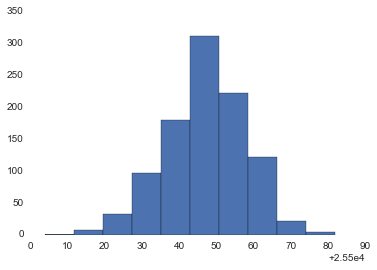

In [498]:
ax = se.hist()

In [499]:
ax.get_xticks()

array([ 25500.,  25510.,  25520.,  25530.,  25540.,  25550.,  25560.,
        25570.,  25580.,  25590.])

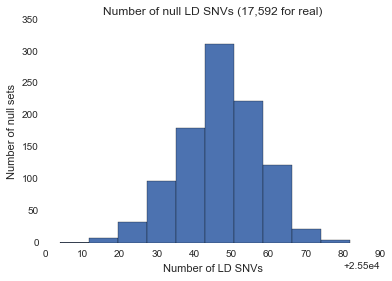

In [443]:
n,b,p = plt.hist([len(x) for x in null_ld_snvs.values()])
plt.title('Number of null LD SNVs ({:,} for real)'.format(len(real_ld_snvs)))
plt.xlabel('Number of LD SNVs')
plt.ylabel('Number of null sets');

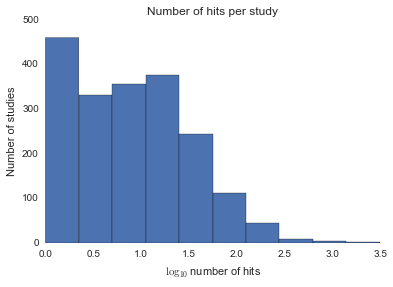

In [444]:
np.log10(gwas.PUBMEDID.value_counts()).hist()
plt.ylabel('Number of studies')
plt.xlabel('$\log_{10}$ number of hits')
plt.title('Number of hits per study');

I'm only going to look at GWAS studies with a reasonable number of hits.
For now, I'll take studies with 10 or more hits.

In [475]:
vc = gwas.PUBMEDID.value_counts()
vc = vc[vc >= 10]

In [479]:
se = pd.Series(dict(zip(gwas.PUBMEDID, gwas['DISEASE/TRAIT'])))

In [481]:
vc = vc[vc >= 200]

In [456]:
vc = gwas.PUBMEDID.value_counts()
vc = vc[vc >= 10]
overlaps = pd.DataFrame(index=vc.index, columns=['real'] + list(null_sets.columns))
for pubmed_id in gwas.PUBMEDID.values:
    # Get GWAS SNVs.
    s = set(gwas.ix[gwas.PUBMEDID == pubmed_id, 'hg19_loc'])
    # Count overlap with real LD SNVs.
    #real_overlap = len(real_ld_snvs & s) / float(len(real_ld_snvs))
    real_overlap = len(real_ld_snvs & s) / float(len(s))
    overlaps.ix[pubmed_id, 'real'] = real_overlap
    # Count overlap with each null set.
    #null_overlap = []
    #for i in null_sets.columns:
    #    overlaps.ix[pubmed_id, i] = len(s & null_ld_snvs[i]) / float(len(null_ld_snvs[i]))
    # Get empirical p-value.
    # Perhaps generate fisher p-value as well? Contingency table is
    # eQTL SNV by in LD with GWAS SNP

In [466]:
vc = gwas.PUBMEDID.value_counts()
vc = vc[vc >= 50]

In [468]:
se = copy.deepcopy(overlaps['real'])
se = se[vc.index]

In [469]:
se.sort(ascending=False)

In [472]:
d = dict(zip(gwas.PUBMEDID, gwas['DISEASE/TRAIT']))

In [473]:
se.index = [d[i] for i in se.index]

In [474]:
se

Age-related macular degeneration                                                                                                                        0.1
Liver enzyme levels (alkaline phosphatase)                                                                                                       0.06976744
Sex hormone-binding globulin levels                                                                                                                  0.0625
Platelet counts                                                                                                                                  0.05555556
Diastolic blood pressure                                                                                                                         0.04761905
Mean corpuscular hemoglobin                                                                                                                            0.04
Hematological parameters                                        

In [ ]:
q

In [115]:
with open('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/sandbox/gwas_stuff/phenotypes.txt') as f:
    lines = [x.strip().split() for x in f.readlines()]
counts = [int(x[0]) for x in lines]
phenos = [' '.join(x[1:]) for x in lines]
se = pd.Series(counts, index=phenos)
se.sort(ascending=False)
se = se[se >= 500]

In [136]:
se[[x for x in se.index if 'cancer' in x.lower()]]

Neuroblastoma (brain cancer)           30570
Prostate cancer                         7134
Breast cancer                           6252
Renal cell carcinoma (renal cancer)     2011
Lung cancer                              762
Colorectal cancer                        650
dtype: int64

In [137]:
se[[x for x in se.index if 'cancer' in x.lower()]]

Neuroblastoma (brain cancer)           30570
Prostate cancer                         7134
Breast cancer                           6252
Renal cell carcinoma (renal cancer)     2011
Lung cancer                              762
Colorectal cancer                        650
dtype: int64

In [138]:
[x for x in se.index if 'blood' in x]

['Fasting blood glucose',
 'Diastolic blood pressure (DBP)',
 'Systolic blood pressure (SBP)',
 'Red blood cell count (RBC)',
 'Gene expression of SLC25A43 in peripheral blood monocytes',
 'Gene expression of CLDN23 in peripheral blood monocytes',
 'Gene expression of SLC25A19 in peripheral blood monocytes',
 'Gene expression of BTN3A2 in peripheral blood monocytes',
 'Gene expression of HLA-A29.1 in peripheral blood monocytes',
 'Gene expression of HLA-DRB1 in peripheral blood monocytes',
 'Gene expression of HLA-DRB5 in peripheral blood monocytes']

In [27]:
grasp[grasp[grasp.columns[11]] == 'Systolic blood pressure (SBP)']

,NHLBIkey,HUPfield,LastCurationDate,CreationDate,SNPid(dbSNP134),chr(hg19),pos(hg19),PMID,SNPid(in paper),LocationWithinPaper,...,dbSNPClinStatus,ORegAnno,ConservPredTFBS,HumanEnhancer,RNAedit,PolyPhen2,SIFT,LS-SNP,UniProt,EqtlMethMetabStudy
17,2190911518,Jan2014,8/17/12,8/17/12,18,7,11597475,21909115,rs18,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2190911521,Jan2014,8/17/12,8/17/12,21,7,11596934,21909115,rs21,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2190911522,Jan2014,8/17/12,8/17/12,22,7,11596502,21909115,rs22,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2190911544,Jan2014,8/17/12,8/17/12,67,7,11615098,21909115,rs67,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2190911546,Jan2014,8/17/12,8/17/12,68,7,11614942,21909115,rs68,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2190911548,Jan2014,8/17/12,8/17/12,69,7,11613172,21909115,rs69,Full Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
grasp = pd.read_table('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/sandbox/gwas_stuff/test.tsv')

In [22]:
grasp.head()

,NHLBIkey,HUPfield,LastCurationDate,CreationDate,SNPid(dbSNP134),chr(hg19),pos(hg19),PMID,SNPid(in paper),LocationWithinPaper,...,dbSNPClinStatus,ORegAnno,ConservPredTFBS,HumanEnhancer,RNAedit,PolyPhen2,SIFT,LS-SNP,UniProt,EqtlMethMetabStudy
0,203831461,Jan2014,8/17/12,8/17/12,3,13,32446842,20383146,rs3,Full Scan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204538422,Jan2014,8/17/12,8/17/12,3,13,32446842,20453842,rs3,FullScan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,175543003,Jan2014,8/17/12,8/17/12,4,13,32447222,17554300,rs4,Webdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,203831464,Jan2014,8/17/12,8/17/12,4,13,32447222,20383146,rs4,Full Scan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204538425,Jan2014,8/17/12,8/17/12,4,13,32447222,20453842,rs4,FullScan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
grasp.head().T

In [94]:
grasp.head()

,NHLBIkey,HUPfield,LastCurationDate,CreationDate,SNPid(dbSNP134),chr(hg19),pos(hg19),PMID,SNPid(in paper),LocationWithinPaper,...,dbSNPClinStatus,ORegAnno,ConservPredTFBS,HumanEnhancer,RNAedit,PolyPhen2,SIFT,LS-SNP,UniProt,EqtlMethMetabStudy
0,203831461,Jan2014,8/17/12,8/17/12,3,13,32446842,20383146,rs3,Full Scan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,204538422,Jan2014,8/17/12,8/17/12,3,13,32446842,20453842,rs3,FullScan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,175543003,Jan2014,8/17/12,8/17/12,4,13,32447222,17554300,rs4,Webdata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,203831464,Jan2014,8/17/12,8/17/12,4,13,32447222,20383146,rs4,Full Scan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,204538425,Jan2014,8/17/12,8/17/12,4,13,32447222,20453842,rs4,FullScan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
grasp.PaperPhenotypeDescription

0         Chronic kidney disease (CKD) and renal traits
1                                  Rheumatoid arthritis
2     Multiple traits (bipolar disorder, coronary ar...
3         Chronic kidney disease (CKD) and renal traits
4                                  Rheumatoid arthritis
5                            Bone mineral density (BMD)
6                            Bone mineral density (BMD)
7           Ovarian failure (premature ovarian failure)
8                                                Height
9                                       Waist:hip ratio
10    Response to statin treatment (simvastatin, pra...
11                             Lipid level measurements
12                             Lipid level measurements
13                                Albuminuria, in urine
14                             Lipid level measurements
15                                               Asthma
16                                 Rheumatoid arthritis
17                                       Blood p

In [93]:
grasp.Phenotype

0                                Chronic kidney disease
1                                  Rheumatoid arthritis
2     Coronary artery disease (CAD), combined contro...
3                                Chronic kidney disease
4                                  Rheumatoid arthritis
5                      Spine bone mineral density (BMD)
6                        Hip bone mineral density (BMD)
7                             Premature ovarian failure
8                                                Height
9                                       Waist hip ratio
10                  HDL cholesterol change with statins
11                                    Total cholesterol
12                                      LDL cholesterol
13                                     Microalbuminuria
14                                        Triglycerides
15                                               Asthma
16                                 Rheumatoid arthritis
17                        Systolic blood pressur

In [92]:
print('\n'.join(grasp.columns))

NHLBIkey
HUPfield
LastCurationDate
CreationDate
SNPid(dbSNP134)
chr(hg19)
pos(hg19)
PMID
SNPid(in paper)
LocationWithinPaper
Pvalue
Phenotype
PaperPhenotypeDescription
PaperPhenotypeCategories
DatePub
InNHGRIcat(as of 3/31/12)
Journal
Title
IncludesMale/Female Only Analyses
Exclusively Male/Female
Initial Sample Description
Replication Sample Description
Platform [SNPs passing QC]
GWASancestryDescription
TotalSamples(discovery+replication)
TotalDiscoverySamples
European Discovery
African Discovery
East Asian Discovery
Indian/South Asian Discovery
Hispanic Discovery
Native Discovery
Micronesian Discovery
Arab/ME Discovery
Mixed Discovery
Unspecified Discovery
Filipino Discovery
Indonesian Discovery
Total replication samples
European Replication
African Replication
East Asian Replication
Indian/South Asian Replication
Hispanic Replication
Native Replication
Micronesian Replication
Arab/ME Replication
Mixed Replication
Unspecified Replication
Filipino Replication
Indonesian Replication
In